In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression

import os
from datetime import datetime, timedelta

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

In [78]:
def correct_angles(data):
    correction_up = [0]  # This variable will store the accumulated correction value
    correction_down = [0]
    up = 0
    down = 0
    for i in range(1, len(data)):
        difference = data[i] - data[i-1]
        # If jump from ~360 to 0
        if difference < -180:
            up += 1
        # If jump from ~0 to 360
        elif difference > 180:
            down += 1
        # Apply correction
        correction_up.append(up)
        correction_down.append(down)
        
    return (correction_up, correction_down)

def round_and_avoid_duplicates(data):
    # Round to the nearest 10
    rounded = np.rint(data / 10.0) * 10
    
    # For each unique element, calculate its adjusted value
    output = np.zeros_like(rounded)
    unique_vals, counts = np.unique(rounded, return_counts=True)
    
    for val, count in zip(unique_vals, counts):
        indices = np.where(rounded == val)[0]
        adjustments = np.arange(count) * 10
        output[indices] = val + adjustments

    return output

def linear_regression_detrend(y):
    """
    Uses linear regression to detrend the data.
    Returns the detrended data.
    """
    X = np.arange(len(y)).reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    
    # Predicted trend
    trend = model.predict(X)
    
    # Detrended data
    detrended = y - trend
    return detrended
    
def normalize_to_range(data, a=-1, b=1):
    X_min = np.min(data)
    X_max = np.max(data)
    
    normalized_data = a + (data - X_min) * (b - a) / (X_max - X_min)
    
    return normalized_data

def load(directory, filename):
    raw_data = pd.read_csv(os.path.join(directory, filename),
                       skiprows=1,
                       delimiter=',',
                       header=None).to_numpy()
    timestamp = raw_data[:, 0] - raw_data[0, 0]
    data = raw_data[:, 1:]
    return timestamp, data

def concatenate_files(directory):
    """
    Loops over files in directory, adjusts their timestamps, and concatenates them.
    """
    all_timestamps = []
    all_data = []

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.csv'):
            timestamps, data = load(directory, filename)
            try:
                timestamps += all_timestamps[-1]
            except:
                pass
            all_timestamps.extend(timestamps)
            all_data.extend(data)

    all_timestamps[-30:] = []
    all_data[-30:] = []

    all_timestamps = np.array(all_timestamps) / 1000 # ms to s
    all_data = np.array(all_data)

    c = all_data[:, 0]
    b = all_data[:, 1]
    tl = all_data[:, 2]
    tr = all_data[:, 3]
    r = all_data[:, 4]
    p = all_data[:, 5]
    y = all_data[:, 6]

    return all_timestamps, c, b, tl, tr, y, p, r

In [79]:
directory = '../dataset/ble_test/yihan_sleep_20231207/'

timestamps, c, b, tl, tr, y, p, r = concatenate_files(directory)

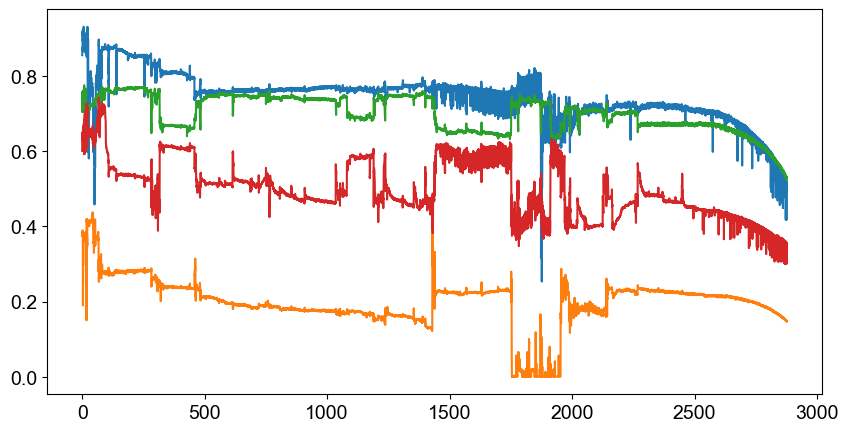

In [80]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot()

ax.plot(timestamps, c)
ax.plot(timestamps, b)
ax.plot(timestamps, tl)
ax.plot(timestamps, tr)
# ax.plot(timestamps, y)
# ax.plot(timestamps, p)
# ax.plot(timestamps, r)

plt.show()

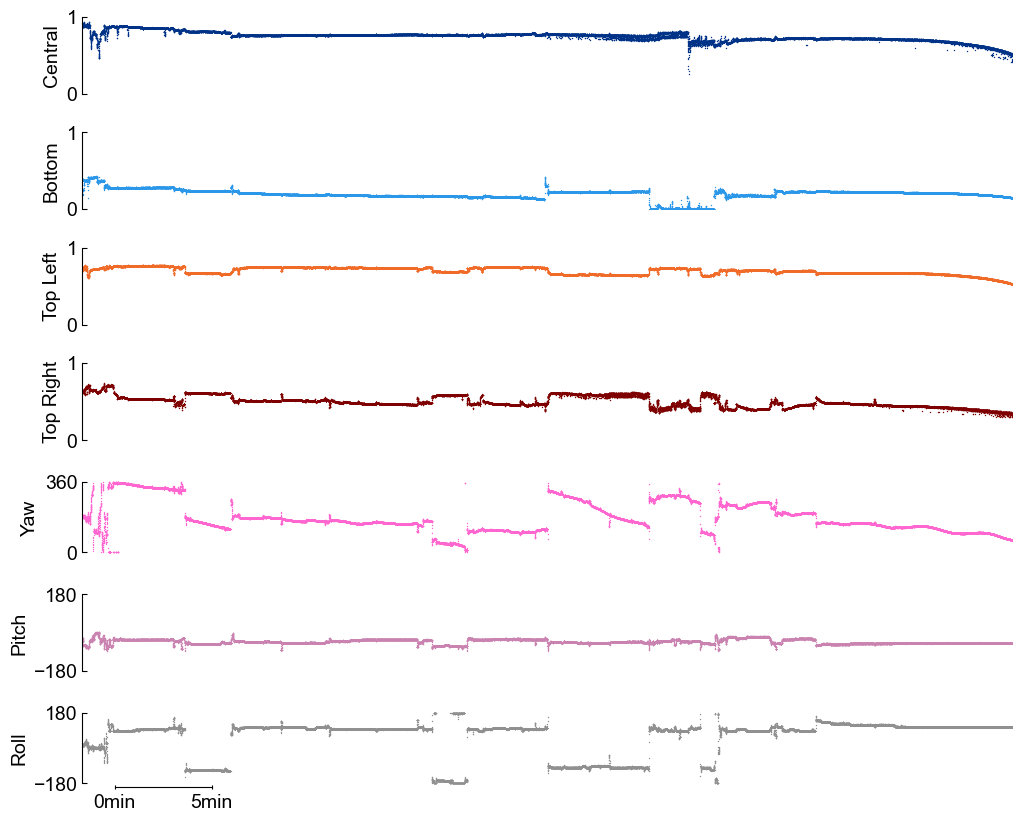

In [89]:
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
labels = ['Central', 'Bottom', 'Top Left', 'Top Right', 'Yaw', 'Pitch', 'Roll']

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=[12, 10], sharex=True)
fig.subplots_adjust(hspace=0.5)

axes[0].plot(timestamps, c, linestyle='None', marker='o', markerfacecolor=pv_color[0], mew=0, ms=1)
axes[1].plot(timestamps, b, linestyle='None', marker='o', markerfacecolor=pv_color[1], mew=0, ms=1)
axes[2].plot(timestamps, tl, linestyle='None', marker='o', markerfacecolor=pv_color[2], mew=0, ms=1)
axes[3].plot(timestamps, tr, linestyle='None', marker='o', markerfacecolor=pv_color[3], mew=0, ms=1)

axes[4].plot(timestamps, y, linestyle='None', marker='o', markerfacecolor=or_color[0], mew=0, ms=1)
axes[5].plot(timestamps, p, linestyle='None', marker='o', markerfacecolor=or_color[1], mew=0, ms=1)
axes[6].plot(timestamps, r, linestyle='None', marker='o', markerfacecolor=or_color[2], mew=0, ms=1)

for idx, ax in enumerate(axes):
    # pv
    if idx < 4:
        ax.set_ylim([0, 1])
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.spines.right.set_visible(False)
        ax.spines.left.set_bounds([0, 1])
        ax.tick_params(axis='y',direction='in')
        ax.set_yticks([0, 1])
    # yaw
    elif idx == 4:   
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.spines.right.set_visible(False)
        ax.spines.left.set_bounds([0, 360])
        ax.tick_params(axis='y',direction='in')
        ax.set_yticks([0, 360])
    # pitch & roll
    elif idx >= 5:
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.spines.right.set_visible(False)
        ax.spines.left.set_bounds([-180, 180])
        ax.tick_params(axis='y',direction='in')
        ax.set_yticks([-180, 180])

for ii, ax in enumerate(axes):
    ax.tick_params(axis='x',which='both',bottom=False,top=False)
    ax.set_ylabel(labels[ii])

axes[-1].set_xlim([timestamps[0], timestamps[-1]])
axes[-1].spines.bottom.set_visible(True)
axes[-1].spines.bottom.set_bounds([100, 400])
axes[-1].tick_params(axis='x',direction='inout',bottom=True)
axes[-1].set_xticks([100, 400], labels=['0min','5min'])

#plt.savefig('../results/fig5/long_test_result.png')
plt.show()

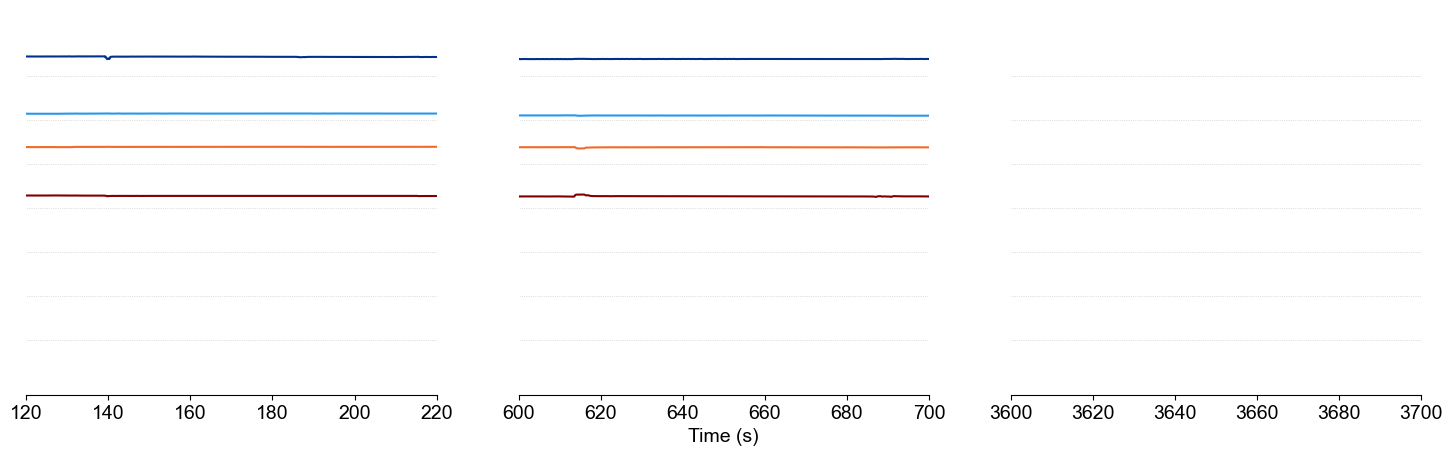

In [94]:
offsets = [[0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0]]

vinterval = 2
start = [120, 600, 3600]

fig,axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 5])

for ii, ax in enumerate(axes):
    offset = offsets[ii]
    line0 = ax.plot(timestamps, c + offset[0] + 6*vinterval, c=pv_color[0])
    line1 = ax.plot(timestamps, b + offset[1] + 5*vinterval, c=pv_color[1])
    line2 = ax.plot(timestamps, tl + offset[2] + 4*vinterval, c=pv_color[2])
    line3 = ax.plot(timestamps, tr + offset[3] + 3*vinterval, c=pv_color[3])

    line4 = ax.plot(timestamps, y + offset[4] + 2*vinterval,
                    linestyle='None', marker='o', markerfacecolor=or_color[0], mew=0, ms=1)
    line5 = ax.plot(timestamps, p + offset[5] + 1*vinterval,
                    linestyle='None', marker='o', markerfacecolor=or_color[1], mew=0, ms=1)
    line6 = ax.plot(timestamps, r + offset[6] + 0*vinterval,
                    linestyle='None', marker='o', markerfacecolor=or_color[2], mew=0, ms=1)

    ax.set_ylim([-2.5, 15])
    # ax.axis('off')

    ax.set_xlim([start[ii], start[ii] + 100])
    ax.hlines([0, 2, 4, 6, 8, 10, 12], 0, len(y), linestyles='dotted', colors='silver', linewidths=0.5)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.get_yaxis().set_visible(False)

axes[1].set_xlabel('Time (s)')
fig.subplots_adjust(hspace=1)
plt.show()
#plt.savefig('../results/fig5/result_9140_to_9150.png')
